# Loading and Wrangling Data

Loading in data using the functions that we made:

In [1]:
oneBatch = True

In [2]:
# Run if you want one batch
import data_loading as dt
import os


if oneBatch:
    batchNum = 1
    if os.path.exists(f'batch{batchNum}/part_{batchNum}/'):
        ids, images = dt.importImages(f'batch{batchNum}/part_{batchNum}/')
    else:
        ids, images = dt.loadImageBatch(batchNum)
else:
    batchNums = list(range(1,13))
    ids, images = dt.loadImageBatches(batchNums)

Getting annotations and getting them into the correct order:

In [3]:
import pandas as pd
annotations = pd.read_csv("data/annotations.csv")
annotations.head()

,position,image
0,standing,1
1,standing,2
2,standing,3
3,standing,4
4,standing,5


In [4]:
position_maps= {"standing": 0, 
                "takedown1": 1,
                "takedown2": 2,
                "open_guard1": 3,
                "open_guard2": 4,
                "half_guard1": 5,
                "half_guard2": 6,
                "closed_guard1": 7,
                "closed_guard2": 8,
                "5050_guard": 9,
                "mount1": 10,
                "mount2": 11,
                "back1": 12,
                "back2": 13,
                "turtle1": 14,
                "turtle2": 15,               
                "side_control1" : 16,
                "side_control2" : 17}


labels = []
for id in ids:
    labels.append(position_maps[annotations[annotations['image'] == id]['position'].reset_index(drop=True)[0]])

In [5]:
labels[0:20]

[3, 8, 7, 3, 4, 3, 4, 3, 3, 3, 8, 7, 3, 8, 7, 3, 3, 4, 4, 3]

Converting images to tensors:

In [6]:
import torch
import numpy as np

# Converting into torch tensors
for i, img in enumerate(images):
    images[i] = torch.from_numpy(np.array(img))

# Convolutional Neural Net: Transfer Learning Squeeze Net

## Creating Neural Net

In [7]:
# Data argumentation
# from torchvision import transforms
# data_transforms = transforms.Compose([
#         transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(degrees=(0, 180))
# ])

# # CNN
# from torch import nn
# import torchvision

# # Transfer Learnin
# regnet_weights = torchvision.models.RegNet_X_400MF_Weights.IMAGENET1K_V2
# regnet_model = torchvision.models.regnet_x_400mf(weights = regnet_weights)
# regnet_model.classifier = torch.nn.Sequential( 
#     torch.nn.Linear(in_features=1000, out_features=18, bias=True))
# torch.manual_seed(7) # For reproduction purposes (should be minor since only the last layers are randomly intialized)
# net = regnet_model
# lrate = 0.001
# optimizer = torch.optim.Adam(net.parameters(), lr=lrate)

# # print(net)
# for param in net.features.parameters():
#     param.requires_grad = True

In [8]:
# Data argumentation
from torchvision import transforms
data_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180))
])

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define the modified SqueezeNet model
class MySqueezeNet(nn.Module):
    def __init__(self, num_classes):
        super(MySqueezeNet, self).__init__()
        self.squeezenet = models.squeezenet1_1(pretrained=False)
        self.num_classes = num_classes
        # self.squeezenet.classifier[1] = torch.nn.Sequential(
        #     nn.Conv2d(512, 256, 3, 1),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 18, 1, 1)
        # )
    
        self.squeezenet.num_classes = self.num_classes
        self.classifier = nn.Sequential(
            nn.Conv2d(1000, 512, 1, 1),
            nn.ReLU(),
            nn.Conv2d(512, self.num_classes, 1, 1)
        )

    def forward(self, x):
        x = self.squeezenet.features(x)
        x = self.squeezenet.classifier(x)
        x = self.classifier(x)

        return x.view(x.size(0), self.num_classes)

# Create an instance of the modified SqueezeNet model
squeeze_model = MySqueezeNet(num_classes=18)
state_dict = torch.load('weights/squeezenet1_1-f364aa15.pth')

# Copy the weights from the pre-trained model to the modified model
pretrained_dict = {k: v for k, v in state_dict.items() if k.startswith('features') or k.startswith('classifier.0')}
model_dict = squeeze_model.squeezenet.state_dict()
model_dict.update(pretrained_dict)
squeeze_model.squeezenet.load_state_dict(model_dict)

# Freeze the parameters of the pre-trained layers
for param in squeeze_model.squeezenet.parameters():
    param.requires_grad = False
    
# for param in squeeze_model.squeezenet.classifier[1].parameters():
#     param.requires_grad = True

# Define the optimizer for the new fully connected layer
lrate = 0.001
# optimizer = optim.Adam(squeeze_model.squeezenet.classifier[1].parameters(), lr=lrate)
optimizer = optim.Adam(squeeze_model.classifier.parameters(), lr=lrate)


## Training Neural Net

Train-test split:

In [10]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    images, labels, test_size=0.25, random_state=42)

train_X = torch.from_numpy(train_X)
train_X = torch.movedim(train_X, source=3, destination=1)

test_X = torch.from_numpy(test_X)
test_X = torch.movedim(test_X, source=3, destination=1)

In [16]:
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
epochs = 10
lrate = 0.01
bsize = 32

# For reproducibility
torch.manual_seed(3)

# Cost Function
cost_fn = nn.CrossEntropyLoss()

# Initialize the model
net = squeeze_model

# Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

# Make DataLoader
y_tensor = torch.Tensor(train_y)
train_loader = DataLoader(TensorDataset(train_X.type(torch.FloatTensor),
                                        y_tensor.type(torch.LongTensor)), batch_size=bsize)

# Training loop
track_cost = np.zeros(epochs)

for epoch in range(epochs):
    cur_cost = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Transform the input data using our data augmentation strategies
        inputs = data_transforms(inputs)

        # Forward, backward, and optimize
        optimizer.zero_grad()
        outputs = net(inputs)
        cost = cost_fn(outputs, labels)  # CrossEntropyLoss already applies Softmax
        cost.backward()
        optimizer.step()

        cur_cost += cost.item()

    # Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(epoch/epochs, f"Epoch: {epoch} Cost: {cur_cost}")
    

0.0 Epoch: 0 Cost: 18481.491540193558
0.1 Epoch: 1 Cost: 548.7083978652954
0.2 Epoch: 2 Cost: 483.71445631980896
0.3 Epoch: 3 Cost: 446.6028083562851
0.4 Epoch: 4 Cost: 421.1401273012161
0.5 Epoch: 5 Cost: 404.04151582717896
0.6 Epoch: 6 Cost: 391.16039288043976
0.7 Epoch: 7 Cost: 381.41526770591736
0.8 Epoch: 8 Cost: 373.8532793521881
0.9 Epoch: 9 Cost: 367.8862934112549


Calculating training accuracy:

In [17]:
## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in train_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Training Accuracy is {correct/total}")

Training Accuracy is 0.3884011705240756


Calculating testing accuracy:

In [18]:

## Combine X and y tensors into a TensorDataset and DataLoader
test_loader = DataLoader(TensorDataset(test_X.type(torch.FloatTensor), 
                        torch.Tensor(test_y).type(torch.LongTensor)), batch_size=bsize)

## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in test_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Test Accuracy is {correct/total}")

Test Accuracy is 0.36671987230646447


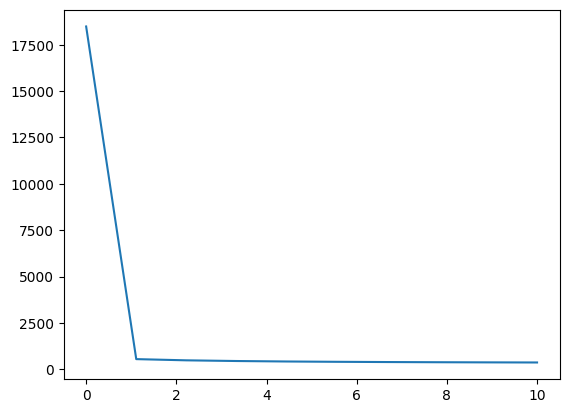

In [19]:
# verifying the convergence of cost
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()